# PyTorch Custom Datasets

## What is a custom dataset?

A **custom dataset** is a collection of data relating to a specific problem you're working on.

In essence, a **custom dataset** can be comprised of almost anything.

For example, if we were building a food image classification app like [Nutrify](https://nutrify.app), our custom dataset might be images of food.

Or if we were trying to build a model to classify whether or not a text-based review on a website was positive or negative, our custom dataset might be examples of existing customer reviews and their ratings.

Or if we were trying to build a sound classification app, our custom dataset might be sound samples alongside their sample labels.

Or if we were trying to build a recommendation system for customers purchasing things on our website, our custom dataset might be examples of products other people have bought.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-domain-libraries.png" alt="different pytorch domain libraries can be used for specific PyTorch problems" width=1000/>

*PyTorch includes many existing functions to load in various custom datasets in the [`TorchVision`](https://pytorch.org/vision/stable/index.html), [`TorchText`](https://pytorch.org/text/stable/index.html), [`TorchAudio`](https://pytorch.org/audio/stable/index.html) and [`TorchRec`](https://pytorch.org/torchrec/) domain libraries.*

But sometimes these existing functions may not be enough.

In that case, we can always subclass `torch.utils.data.Dataset` and customize it to our liking.

## What we're going to cover

We're going to be applying the PyTorch Workflow we covered in [notebook 01](https://www.learnpytorch.io/01_pytorch_workflow/) and [notebook 02](https://www.learnpytorch.io/02_pytorch_classification/) to a computer vision problem.

But instead of using an in-built PyTorch dataset, we're going to be using our own dataset of pizza, steak and sushi images.

The goal will be to load these images and then build a model to train and predict on them.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-food-vision-layout.png" alt="building a pipeline to load in food images and then building a pytorch model to classify those food images" width=800 />

*What we're going to build. We'll use `torchvision.datasets` as well as our own custom `Dataset` class to load in images of food and then we'll build a PyTorch computer vision model to hopefully be able to classify them.*

Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **0. Importing PyTorch and setting up device-agnostic code** | Let's get PyTorch loaded and then follow best practice to setup our code to be device-agnostic.  |
| **1. Get data** | We're going to be using our own **custom dataset** of pizza, steak and sushi images. |
| **2. Become one with the data (data preparation)** | At the beginning of any new machine learning problem, it's paramount to understand the data you're working with. Here we'll take some steps to figure out what data we have. |
| **3. Transforming data** |Often, the data you get won't be 100% ready to use with a machine learning model, here we'll look at some steps we can take to *transform* our images so they're ready to be used with a model. | 
| **4. Loading data with `ImageFolder` (option 1)** | PyTorch has many in-built data loading functions for common types of data. `ImageFolder` is helpful if our images are in standard image classification format. |
| **5. Loading image data with a custom `Dataset`** | What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of `torch.utils.data.Dataset`. |
| **6. Other forms of transforms (data augmentation)** | Data augmentation is a common technique for expanding the diversity of your training data. Here we'll explore some of `torchvision`'s in-built data augmentation functions. |
| **7. Model 0: TinyVGG without data augmentation** | By this stage, we'll have our data ready, let's build a model capable of fitting it. We'll also create some training and testing functions for training and evaluating our model. |
| **8. Exploring loss curves** | Loss curves are a great way to see how your model is training/improving over time. They're also a good way to see if your model is **underfitting** or **overfitting**. |
| **9. Model 1: TinyVGG with data augmentation** | By now, we've tried a model *without*, how about we try one *with* data augmentation? |
| **10. Compare model results** | Let's compare our different models' loss curves and see which performed better and discuss some options for improving performance. |
| **11. Making a prediction on a custom image** | Our model is trained to on a dataset of pizza, steak and sushi images. In this section we'll cover how to use our trained model to predict on an image *outside* of our existing dataset. |

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch 
from torch import nn 

In [2]:
# setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

The data we're going to be using is a subset of the [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).

Food101 is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).

Instead of 101 food classes though, we're going to start with 3: pizza, steak and sushi.

And instead of 1,000 images per class, we're going to start with a random 10% (start small, increase when necessary).

If you'd like to see where the data came from you see the following resources:
* Original [Food101 dataset and paper website](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).
* [`torchvision.datasets.Food101`](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html) - the version of the data I downloaded for this notebook.
* [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) - a notebook I used to format the Food101 dataset to use for this notebook.
* [`data/pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip) - the zip archive of pizza, steak and sushi images from Food101, created with the notebook linked above.

Let's write some code to download the formatted data from GitHub.

> **Note:** The dataset we're about to use has been pre-formatted for what we'd like to use it for. However, you'll often have to format your own datasets for whatever problem you're working on. This is a regular practice in the machine learning world.

In [3]:
import requests
import zipfile
from pathlib import Path

# setup path to the data 
data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

# if the folder doesn't exist download it and prepare it
if image_path.is_dir(): 
    print(f"{image_path} directory already exists... skipping download")
else: 
    print(f"{image_path} doesn't exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data 
with open(data_path / "pizza_steak_sushi.zip", "wb") as f: 
    request =  requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print(f"Downloading pizza_steak_sushi.zip...")
    f.write(request.content)

# Unzip pizza_steak_sushi.zip
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref: 
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists... skipping download


## 2. Become one with the data (data preparation)

This is another important step before building a model.

As Abraham Lossfunction said...

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-abraham-lossfunction.png" alt="tweet by mrdbourke, if I had eight hours to build a machine learning model, I'd spend the first 6 hours preparing my dataset" width=800/>

What's inspecting the data and becoming one with it? 

Before starting a project or building any kind of model, it's important to know what data you're working with.

In our case, we have images of pizza, steak and sushi in standard image classification format.

Image classification format contains separate classes of images in separate directories titled with a particular class name.

For example, all images of `pizza` are contained in the `pizza/` directory.

This format is popular across many different image classification benchmarks, including [ImageNet](https://www.image-net.org/) (of the most popular computer vision benchmark datasets).

You can see an example of the storage format below, the images numbers are arbitrary.

```
pizza_steak_sushi/ <- overall dataset folder
    train/ <- training images
        pizza/ <- class name as folder name
            image01.jpeg
            image02.jpeg
            ...
        steak/
            image24.jpeg
            image25.jpeg
            ...
        sushi/
            image37.jpeg
            ...
    test/ <- testing images
        pizza/
            image101.jpeg
            image102.jpeg
            ...
        steak/
            image154.jpeg
            image155.jpeg
            ...
        sushi/
            image167.jpeg
            ...
```

The goal will be to **take this data storage structure and turn it into a dataset usable with PyTorch**.

> **Note:** The structure of the data you work with will vary depending on the problem you're working on. But the premise still remains: become one with the data, then find a way to best turn it into a dataset compatible with PyTorch.

We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present.

To do so, we'll use Python's in-built [`os.walk()`](https://docs.python.org/3/library/os.html#os.walk). 

In [4]:
import os
def walk_through_dir(dir_path): 
    for dirpath, dirnames, filenames in os.walk(dir_path): 
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [5]:
# setup training and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image

Let's write some code to:
1. Get all of the image paths using [`pathlib.Path.glob()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob) to find all of the files ending in `.jpg`. 
2. Pick a random image path using Python's [`random.choice()`](https://docs.python.org/3/library/random.html#random.choice).
3. Get the image class name using [`pathlib.Path.parent.stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.parent).
4. And since we're working with images, we'll open the random image path using [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open) (PIL stands for Python Image Library).
5. We'll then show the image and print some metadata.

Random Image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


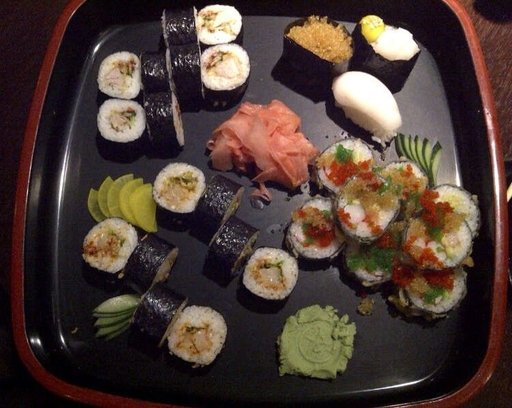

In [6]:
import random
from PIL import Image

# Set seed 
random.seed(42)

# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image 
random_image_path = random.choice(image_path_list)

# 3. Get the image class name 
random_image_class = random_image_path.parent.stem

# 4. Open the image 
img = Image.open(random_image_path)

# 5. Print Metadata 
print(f"Random Image path: {random_image_path}")
print(f"Image class: {random_image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

We can do the same with [`matplotlib.pyplot.imshow()`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.imshow.html), except we have to convert the image to a NumPy array first.

(-0.5, 511.5, 407.5, -0.5)

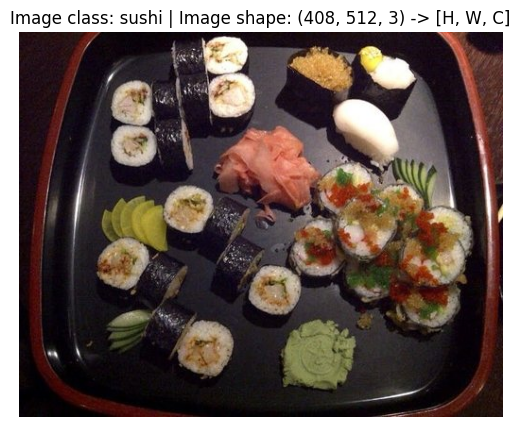

In [7]:
import numpy as np 
import matplotlib.pyplot as plt 

# Turn image into array 
img_array = np.asarray(img)

# Plot the image 
plt.figure(figsize=(7,5))
plt.imshow(img_array)
plt.title(f"Image class: {random_image_class} | Image shape: {img_array.shape} -> [H, W, C]")
plt.axis(False)

## 3. Transforming data 

Before we can use our image data with PyTorch we need to:

1. Turn it into tensors (numerical representations of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader` for short.

There are several different kinds of pre-built datasets and dataset loaders for PyTorch, depending on the problem you're working on. 

| **Problem space** | **Pre-built Datasets and Functions** |
| ----- | ----- |
| **Vision** | [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) |
| **Audio** | [`torchaudio.datasets`](https://pytorch.org/audio/stable/datasets.html) |
| **Text** | [`torchtext.datasets`](https://pytorch.org/text/stable/datasets.html) |
| **Recommendation system** | [`torchrec.datasets`](https://pytorch.org/torchrec/torchrec.datasets.html) |

Since we're working with a vision problem, we'll be looking at `torchvision.datasets` for our data loading functions as well as [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) for preparing our data.

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

`torchvision.transforms` contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for **data augmentation** (the practice of altering data to make it harder for a model to learn, we'll see this later on) purposes . 

To get experience with `torchvision.transforms`, let's write a series of transform steps that:
1. Resize the images using [`transforms.Resize()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize) (from about 512x512 to 64x64, the same shape as the images on the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/)).
2. Flip our images randomly on the horizontal using [`transforms.RandomHorizontalFlip()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip) (this could be considered a form of data augmentation because it will artificially change our image data).
3. Turn our images from a PIL image to a PyTorch tensor using [`transforms.ToTensor()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor).

We can compile all of these steps using [`torchvision.transforms.Compose()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose).

In [9]:
data_transform = transforms.Compose([
    # Resize the image to 64x64
    transforms.Resize(size=(64, 64)), 
    # Flip images randomly on the horizontal 
    transforms.RandomHorizontalFlip(p=0.5), 
    # Turn the images into a troch tensor 
    transforms.ToTensor()
])

In [10]:
transformed_image = data_transform(img)
transformed_image.shape, transformed_image.dtype

(torch.Size([3, 64, 64]), torch.float32)

Now we've got a composition of transforms, let's write a function to try them out on various images.

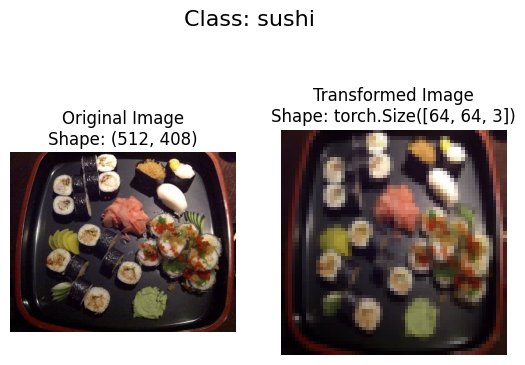

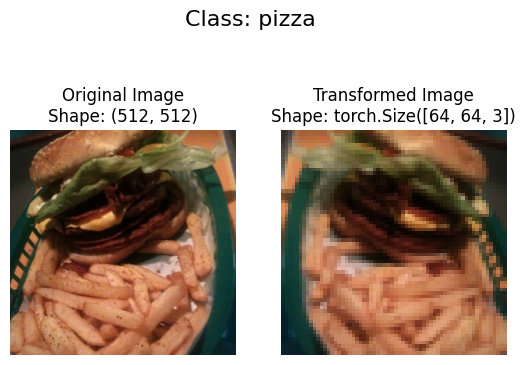

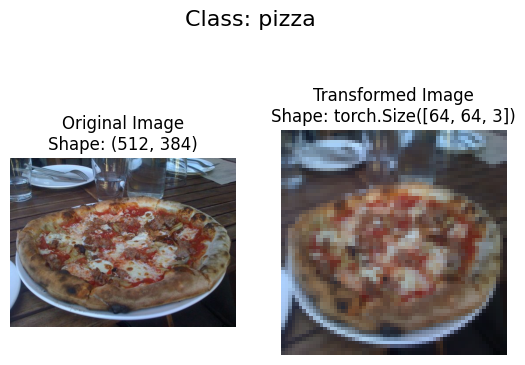

In [11]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None): 
    """
    Selects random images from the path of images and loads/transforms them
    then plots the original vs transformed images.
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n) 
    for image_path in random_image_paths: 
        with Image.open(image_path) as f: 
            # Plot the original image
            fig, ax = plt.subplots(nrows=1, ncols=2) 
            ax[0].imshow(f) 
            ax[0].set_title(f"Original Image\nShape: {f.size}")
            ax[0].axis(False) 

            # Transforme and plot image
            transformed_image = transform(f).permute(1,2,0) # Changing shape for matplotlib [C, H, W] -> [H, W, C] 
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed Image\nShape: {transformed_image.shape}")
            ax[1].axis("off") 

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list, 
                        transform=data_transform, 
                        n=3,
                        seed=42)

## 4. Option 1: Loading Image Data Using [`ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder)

Since our data is in standard image classification format, we can use the class [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder).

Where we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.

Let's test it out on our data folders `train_dir` and `test_dir` passing in `transform=data_transform` to turn our images into tensors.

In [12]:
# Use ImageFolder to create the dataset
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,  
                                  transform=data_transform, # a transform for the data 
                                  target_transform=None)    # a transform for the target/label

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [13]:
# Get class names as list 
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Get class names as dict 
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
# Get a single image and label indexing the dataset 
img, label = train_data[0][0], train_data[0][1] 
print(f"Image Tensor: {img}") 
print(f"Image Shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image Label: {label}") 
print(f"Lable datatype: {type(label)}")

Image Tensor: tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64]) -> [C, H, W]
Image permute: torch.Size([64, 64, 3]) -> [H, W, C]


(-0.5, 63.5, 63.5, -0.5)

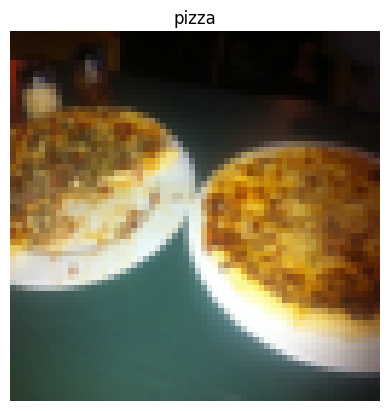

In [16]:
# Rearrang the image dimension for matplotlib 
image_permute = img.permute(1, 2, 0) 
print(f"Original shape: {img.shape} -> [C, H, W]")
print(f"Image permute: {image_permute.shape} -> [H, W, C]")

# Plot the image 
plt.imshow(image_permute)
plt.title(class_names[label]) 
plt.axis(False)

### 4.1 Turn loaded images into `DataLoader`'s

We've got our images as PyTorch `Dataset`'s but now let's turn them into `DataLoader`'s.

We'll do so using [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

Turning our `Dataset`'s into `DataLoader`'s makes them iterable so a model can go through and learn the relationships between samples and targets (features and labels).

To keep things simple, we'll use a `batch_size=1` and `num_workers=1`.

What's `num_workers`?

It defines how many subprocesses will be created to load your data.

Think of it like this, the higher value `num_workers` is set to, the more compute power PyTorch will use to load your data.

Personally, I usually set it to the total number of CPUs on my machine via Python's [`os.cpu_count()`](https://docs.python.org/3/library/os.html#os.cpu_count).

This ensures the `DataLoader` recruits as many cores as possible to load data.

> **Note:** There are more parameters you can get familiar with using `torch.utils.data.DataLoader` in the [PyTorch documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

In [17]:
# Turn train and test data into dataloaders
BATCH_SIZE = 1
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, 
                              num_workers=1, 
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=1)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2b2f608f740>,
 <torch.utils.data.dataloader.DataLoader at 0x2b2f4eecb90>)

In [18]:
len(train_dataloader), len(test_dataloader)

(225, 75)

## 5. Option 2: Loading Image Data with a Custom `Dataset`

What if a pre-built `Dataset` creator like [`torchvision.datasets.ImageFolder()`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder) didn't exist?

Or one for your specific problem didn't exist?

Well, you could build your own.

But wait, what are the pros and cons of creating your own custom way to load `Dataset`'s?

| Pros of creating a custom `Dataset` | Cons of creating a custom `Dataset` |
| ----- | ----- |
| Can create a `Dataset` out of almost anything. | Even though you *could* create a `Dataset` out of almost anything, it doesn't mean it will work. | 
| Not limited to PyTorch pre-built `Dataset` functions. | Using a custom `Dataset` often results in writing more code, which could be prone to errors or performance issues. |

To see this in action, let's work towards replicating `torchvision.datasets.ImageFolder()` by subclassing `torch.utils.data.Dataset` (the base class for all `Dataset`'s in PyTorch). 

We'll start by importing the modules we need:
* Python's `os` for dealing with directories (our data is stored in directories).
* Python's `pathlib` for dealing with filepaths (each of our images has a unique filepath).
* `torch` for all things PyTorch.
* PIL's `Image` class for loading images.
* `torch.utils.data.Dataset` to subclass and create our own custom `Dataset`.
* `torchvision.transforms` to turn our images into tensors.
* Various types from Python's `typing` module to add type hints to our code.

> **Note:** You can customize the following steps for your own dataset. The premise remains: write code to load your data in the format you'd like it.

In [19]:
import os 
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

Remember how our instances of `torchvision.datasets.ImageFolder()` allowed us to use the `classes` and `class_to_idx` attributes?

In [20]:
# Instance of torchvision.datasets.ImageFolder() 
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

Let's write a helper function capable of creating a list of class names and a dictionary of class names and their indexes given a directory path.

To do so, we'll:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dictionary of numerical labels, one for each class.

Let's see a small example of step 1 before we write the full function.

In [21]:
# Setup the path for target direcotry 
target_dir = train_dir
print(f"Target directory: {target_dir}")

# Get class names from the target directory
print(list(os.scandir(target_dir)))
# os.scandir() returns DirEntry, so to get names we use entry.name
class_names_found = sorted([entry.name for entry in list(os.scandir(target_dir))]) 
print(f"Labels: {class_names_found}")

Target directory: data\pizza_steak_sushi\train
[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]
Labels: ['pizza', 'steak', 'sushi']


In [22]:
# Create a function to get class names 
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]: 
    """ Finds the class folder names in a target directory... """ 
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(target_dir) if entry.is_dir())

    # 2. Raise an error if the class names aren't found 
    if not classes: 
        raise FileNotFoundError(f"Couldn't find any classes in {target_dir}... please check the file structure")

    # 3. Create a dictionary of index labels 
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

Now we're ready to build our own custom `Dataset`.

We'll build one to replicate the functionality of `torchvision.datasets.ImageFolder()`. 

This will be good practice, plus, it'll reveal a few of the required steps to make your own custom `Dataset`.

Let's break it down:
1. Subclass `torch.utils.data.Dataset`.
2. Initialize our subclass with a `targ_dir` parameter (the target data directory) and `transform` parameter (so we have the option to transform our data if needed).
3. Create several attributes for
   * `paths` (the paths of our target images),
   * `transform` (the transforms we might like to use, this can be `None`),
   * `classes` and `class_to_idx` (from our `find_classes()` function).
5. Create a function to load images from file and return them, this could be using `PIL` or [`torchvision.io`](https://pytorch.org/vision/stable/io.html#image) (for input/output of vision data). 
6. Overwrite the `__len__` method of `torch.utils.data.Dataset` to return the number of samples in the `Dataset`, this is recommended but not required. This is so you can call `len(Dataset)`.
7. Overwrite the `__getitem__` method of `torch.utils.data.Dataset` to return a single sample from the `Dataset`, this is required.

In [23]:
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset): 
    # 2. Initialize our custom dataset 
    def __init__(self, 
                 targ_dir: str, 
                 transform=None):
        # Get paths of all images
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transform 
        self.transform=transform
        # 3. Create classes, class_to_idx attributs
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Create a function to load image 
    def load_image(self, index: int) -> Image.Image: 
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__ method 
    def __len__(self) -> int: 
        "Returns the total number of samples" 
        return len(self.paths)

    # 6. Overwrite the __getitem__ method 
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data (X, y)" 
        img = self.load_image(index) 
        class_name = self.paths[index].parent.name  # expects the path in the format data_dir/class_dir/image.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary 
        if self.transform: 
            return self.transform(img), class_idx  # return (X, y)
        else: 
            return img, class_idx
    

In [24]:
# Create a transform 
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)), 
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)), 
    transforms.ToTensor()
])

In [25]:
# Test out the ImageFolderCustom 
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir, 
                                     transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x2b2f63aca10>,
 <__main__.ImageFolderCustom at 0x2b2f63269c0>)

In [26]:
len(train_data), len(train_data_custom)

(225, 225)

In [27]:
len(test_data), len(test_data_custom)

(75, 75)

In [28]:
# check for equality between the original ImageFolder Dataset and ImageFolderCustom Dataset 
print(train_data.classes==train_data_custom.classes) 
print(test_data.classes==test_data_custom.classes)


True
True


### 5.3 Create a function to display random images

Let's create a helper function called `display_random_images()` that helps us visualize images in our `Dataset'`s.

Specifically, it'll:
1. Take in a `Dataset` and a number of other parameters such as `classes` (the names of our target classes), the number of images to display (`n`) and a random seed. 
2. To prevent the display getting out of hand, we'll cap `n` at 10 images.
3. Set the random seed for reproducible plots (if `seed` is set). 
4. Get a list of random sample indexes (we can use Python's `random.sample()` for this) to plot.
5. Setup a `matplotlib` plot.
6. Loop through the random sample indexes found in step 4 and plot them with `matplotlib`.
7. Make sure the sample images are of shape `HWC` (height, width, color channels) so we can plot them.

In [29]:
# 1. Create a function to take in a dataset 
def display_random_images(dataset: torch.utils.data.Dataset, 
                          classes: List[str] = None, 
                          n: int = 10, 
                          display_shape: bool = True, 
                          seed: int = None):

    # 2. Adjust display if n>10 
    if n>10: 
        n = 10 
        print(f"For display purpose, n shouldn't be larger than 10, setting n=10")
    if n>5:
        print("Removing shape display as n>5")
        display_shape=False
    # 3. set random seed if seed is set
    if seed: 
        random.seed(seed)
        
    # 4. Get a list of random indexes 
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    
    # 5. Setup matplotlib 
    plt.figure(figsize=(16, 8))
    
    # 6. Loop through random indexes and plot them with matplotlib 
    for i, targ_sample in enumerate(random_samples_idx): 
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
    
        # 7. Adjust dimension for plotting from [C, H, W] -> [H, W, C]
        targ_image_adjust = targ_image.permute(1,2,0) 
    
        # Plot the samples
        plt.subplot(1, n, i+1) 
        plt.imshow(targ_image_adjust)
        plt.axis(False) 
        if classes: 
            title = f"Class: {classes[targ_label]}"
        if display_shape: 
            title = title + f"\nShape: {targ_image_adjust.shape}"
        plt.title(title)

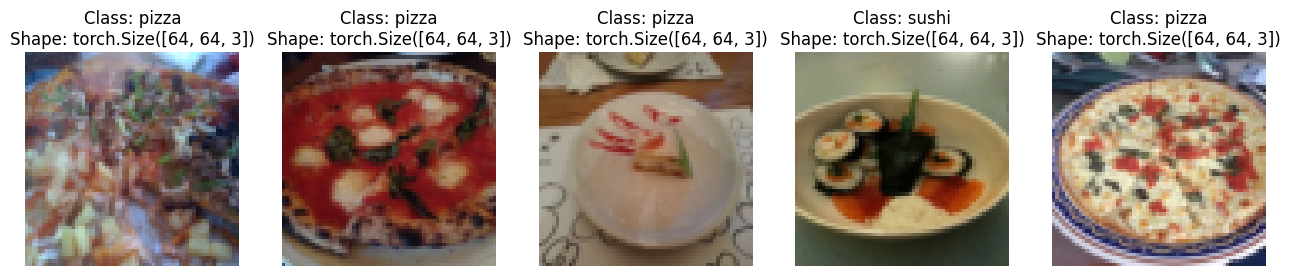

In [30]:
# Display random images form the ImageFolder created Dataset 
display_random_images(train_data_custom, 
                      n=5, 
                      classes=class_names, 
                      seed=None)

### 5.4 Turn custom loaded images into `DataLoader`'s 

Now how could we turn our custom `Dataset`'s into `DataLoader`'s?

If you guessed by using `torch.utils.data.DataLoader()`, you'd be right!

Because our custom `Dataset`'s subclass `torch.utils.data.Dataset`, we can use them directly with `torch.utils.data.DataLoader()`.

And we can do using very similar steps to before except this time we'll be using our custom created `Dataset`'s.

In [31]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32 
NUM_WORKERS = 0

# Create train dataloader 
train_dataloader_custom = DataLoader(dataset=train_data_custom, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_custom = DataLoader(dataset=test_data_custom, 
                                    batch_size=BATCH_SIZE, 
                                    num_workers=NUM_WORKERS)


In [32]:
# Get image and label from custom dataloader 
image_custom, label_custom =  next(iter(train_dataloader_custom))
image_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

We've seen a couple of transforms on our data already but there's plenty more.

You can see them all in the [`torchvision.transforms` documentation](https://pytorch.org/vision/stable/transforms.html).

The purpose of tranforms is to alter your images in some way. That may be turning your images into a tensor (as we've seen before). Or cropping it or randomly erasing a portion or randomly rotating them.

Doing these kinds of transforms is often referred to as **data augmentation**.

**Data augmentation** is the process of altering your data in such a way that you *artificially* increase the diversity of your training set.

Training a model on this *artificially* altered dataset hopefully results in a model that is capable of better *generalization* (the patterns it learns are more robust to future unseen examples).

You can see many different examples of data augmentation performed on images using `torchvision.transforms` in PyTorch's [Illustration of Transforms example](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html).

Machine learning is all about harnessing the power of randomness and research shows that random transforms (like [`transforms.RandAugment()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#randaugment) and [`transforms.TrivialAugmentWide()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#trivialaugmentwide)) generally perform better than hand-picked transforms.

The idea behind [TrivialAugment](https://arxiv.org/abs/2103.10158) is... well, trivial. 

You have a set of transforms and you randomly pick a number of them to perform on an image and at a random magnitude between a given range (a higher magnitude means more instense).

The PyTorch team even [used TrivialAugment it to train their latest state-of-the-art vision models](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements).

![trivial augment data augmentation being used for PyTorch state of the art training](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-trivial-augment-being-using-in-PyTorch-resize.png)

*TrivialAugment was one of the ingredients used in a recent state of the art training upgrade to various PyTorch vision models.*

How about we test it out on some of our own images?

The main parameter to pay attention to in `transforms.TrivialAugmentWide()` is `num_magnitude_bins=31`.

It defines how much of a range an intensity value will be picked to apply a certain transform, `0` being no range and `31` being maximum range (highest chance for highest intensity). 

We can incorporate `transforms.TrivialAugmentWide()` into `transforms.Compose()`.

In [33]:
# Let's look at trivialaugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)), 
    transforms.TrivialAugmentWide(num_magnitude_bins=31), 
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)), 
    transforms.ToTensor()
])


In [34]:
# Get all the image paths 
image_path_list = list(image_path.glob("*/*/*.jpg")) 
image_path_list[:10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

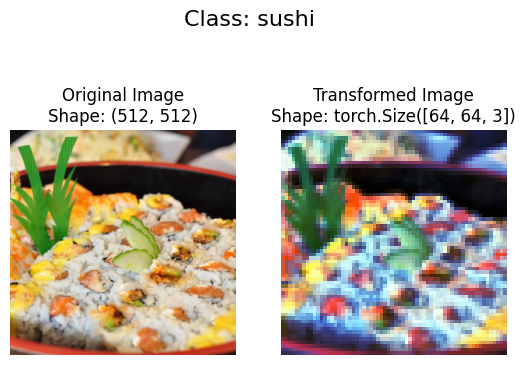

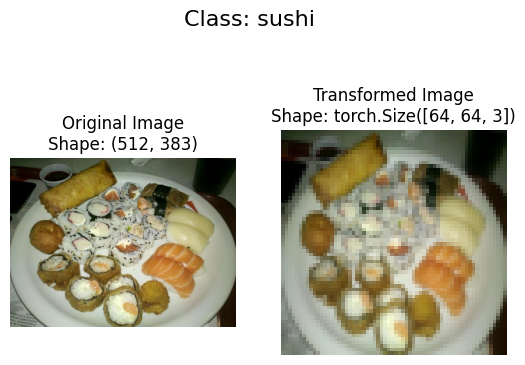

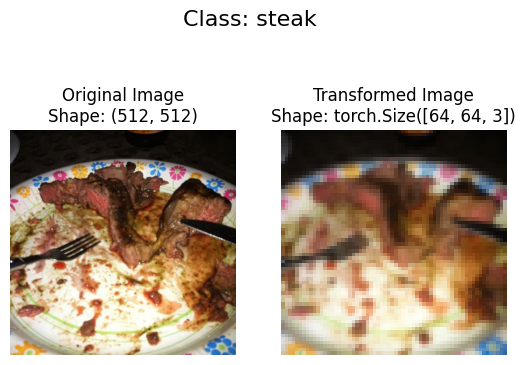

In [35]:
# Plot random transformed images 
plot_transformed_images(image_path_list, 
                        transform=train_transform, 
                        n=3)

## 7. Model 0: TinyVGG without data augmentation

Now let's construct a computer vision model to see if we can classify if an image is of pizza, steak or sushi.

To begin, we'll start with a simple transform, only resizing the images to `(64, 64)` and turning them into tensors.

### 7.1 Creating transforms and loading data for Model 0

In [36]:
# Creating simple transform 
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)), 
    transforms.ToTensor()
])


In [37]:
# 1. Load and transform data 
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, 
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, 
                                        transform=simple_transform)
# 2. Turn the datasets into dataloaders 
import os 
from torch.utils.data import DataLoader

# Setup batch size and num_workers 
BATCH_SIZE = 32
NUM_WORKERS = 0 

# create dataloaders 
train_dataloader_simple = DataLoader(dataset=train_data_simple, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS) 
test_dataloader_simple = DataLoader(dataset=test_data_custom, 
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS) 


### 7.2 Create TinyVGG model class

In [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/#7-model-2-building-a-convolutional-neural-network-cnn), we used the TinyVGG model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

Let's recreate the same model, except this time we'll be using color images instead of grayscale (`in_channels=3` instead of `in_channels=1` for RGB pixels). 

In [38]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, 
                 input_shape: int, 
                 hidden_units: int, 
                 output_shape:int) -> None:
        super().__init__() 
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1), 
            nn.ReLU(), 
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, 
                         stride=2)  # defaulat stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1), 
            nn.ReLU(), 
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, 
                         stride=2)  # defaulat stride value is same as kernel_size
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=hidden_units*16*16, 
                      out_features=output_shape)
        )

    def forward(self, x): 
        x = self.conv_block_1(x)
        x = self.conv_block_2(x) 
        x = self.classifier(x)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion 
        
        

> **Note:** One of the ways to speed up deep learning models computing on a GPU is to leverage **operator fusion**.
>
> This means in the `forward()` method in our model above, instead of calling a layer block and reassigning `x` every time, we call each block in succession (see the final line of the `forward()` method in the model above for an example).
>
> This saves the time spent reassigning `x` (memory heavy) and focuses on only computing on `x`.
> 
> See [*Making Deep Learning Go Brrrr From First Principles*](https://horace.io/brrr_intro.html) by Horace He for more ways on how to speed up machine learning models.



In [39]:
torch.manual_seed(42) 
model_0 = TinyVGG(input_shape=3, 
                  hidden_units=10, 
                  output_shape=len(class_names)).to(device) 
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

A good way to test a model is to do a forward pass on a single piece of data. It's also handy way to test the input and output shapes of our different layers.

To do a forward pass on a single image, let's:
1. Get a batch of images and labels from the `DataLoader`.
2. Get a single image from the batch and `unsqueeze()` the image so it has a batch size of `1` (so its shape fits the model).
3. Perform inference on a single image (making sure to send the image to the target `device`).
4. Print out what's happening and convert the model's raw output logits to prediction probabilities with `torch.softmax()` (since we're working with multi-class data) and convert the prediction probabilities to prediction labels with `torch.argmax()`.

In [40]:
image_batch, label_batch = next(iter(train_dataloader_simple)) 

image_batch.shape

torch.Size([32, 3, 64, 64])

In [41]:
# try a forward pass 
model_0(image_batch.to(device))

tensor([[0.0578, 0.0634, 0.0351],
        [0.0657, 0.0650, 0.0398],
        [0.0702, 0.0678, 0.0412],
        [0.0687, 0.0646, 0.0417],
        [0.0625, 0.0613, 0.0355],
        [0.0587, 0.0595, 0.0358],
        [0.0634, 0.0637, 0.0376],
        [0.0653, 0.0615, 0.0376],
        [0.0678, 0.0621, 0.0349],
        [0.0620, 0.0599, 0.0371],
        [0.0607, 0.0628, 0.0387],
        [0.0638, 0.0589, 0.0352],
        [0.0658, 0.0611, 0.0369],
        [0.0703, 0.0689, 0.0330],
        [0.0557, 0.0571, 0.0356],
        [0.0632, 0.0642, 0.0388],
        [0.0639, 0.0616, 0.0375],
        [0.0605, 0.0600, 0.0374],
        [0.0623, 0.0627, 0.0368],
        [0.0740, 0.0676, 0.0400],
        [0.0621, 0.0613, 0.0361],
        [0.0632, 0.0599, 0.0366],
        [0.0662, 0.0627, 0.0334],
        [0.0637, 0.0622, 0.0394],
        [0.0670, 0.0666, 0.0363],
        [0.0650, 0.0601, 0.0405],
        [0.0639, 0.0597, 0.0395],
        [0.0733, 0.0687, 0.0412],
        [0.0697, 0.0631, 0.0402],
        [0.062

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

Printing out our model with `print(model)` gives us an idea of what's going on with our model.

And we can print out the shapes of our data throughout the `forward()` method.

However, a helpful way to get information from our model is to use [`torchinfo`](https://github.com/TylerYep/torchinfo).

`torchinfo` comes with a `summary()` method that takes a PyTorch model as well as an `input_shape` and returns what happens as a tensor moves through your model.

> **Note:** If you're using Google Colab, you'll need to install `torchinfo`.

In [42]:
try: 
    import torchinfo 
except: 
    !pip install torchinfo

In [43]:
from torchinfo import summary 
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 7.5 Create train & test loop functions 

Now let's make some training and test loop functions to train our model on the training data and evaluate our model on the testing data.

Specifically, we're going to make three functions:
1. `train_step()` - takes in a model, a `DataLoader`, a loss function and an optimizer and trains the model on the `DataLoader`.
2. `test_step()` - takes in a model, a `DataLoader` and a loss function and evaluates the model on the `DataLoader`.
3. `train()` - performs 1. and 2. together for a given number of epochs and returns a results dictionary.

> **Note:** We covered the steps in a PyTorch opimization loop in [notebook 01](https://www.learnpytorch.io/01_pytorch_workflow/#creating-an-optimization-loop-in-pytorch), as well as the[ Unofficial PyTorch Optimization Loop Song](https://youtu.be/Nutpusq_AFw) and we've built similar functions in [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/#62-functionizing-training-and-test-loops).

Let's start by building `train_step()`.

Because we're dealing with batches in the `DataLoader`'s, we'll accumulate the model loss and accuracy values during training (by adding them up for each batch) and then adjust them at the end before we return them.

In [44]:
# Create train step function 
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer, 
               device: torch.device = device): 
    # Put the model on train mode 
    model.train() 

    # Setup loss and accuracy 
    train_loss, train_acc = 0, 0 

    # Loop through data 
    for batch, (X, y) in enumerate(dataloader): 
        # Send data to target device 
        X, y = X.to(device), y.to(device) 

        # 1. Forward Pass 
        y_pred = model(X)  # outputs logits 
        
        # 2. Accumulate loss  
        loss = loss_fn(y_pred, y) 
        train_loss += loss 
        
        # 3. Optimizer zero grad 
        optimizer.zero_grad() 

        # 4. Loss backward 
        loss.backward() 

        # 5. Optimizer step (gradient descent) 
        optimizer.step() 

        # 6. Calculate accuracy metric 
        y_pred_classes = torch.argmax(torch.softmax(y_pred, dim=1), dim=1) # logits -> probs -> classes
        train_acc += (y_pred_classes == y).sum().item()/len(y_pred) 

    # Adjust metrics to get average values per batch 
    train_loss /= len(dataloader) 
    train_acc /= len(dataloader)
    return train_loss, train_acc


In [45]:
# Create test step function 
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module, 
              device: torch.device = device): 
    # Put the model in evaluation mode 
    model.eval()
    
    # Setup loss and accuracy 
    test_loss, test_acc = 0, 0 

    # Turn on inference mode
    with torch.inference_mode(): 

        # Loop through data 
        for batch, (X, y) in enumerate(dataloader): 

            # Send data to device 
            X, y = X.to(device), y.to(device) 

            # 1. Forward Pass 
            y_pred_test = model(X)  # output logits 

            # 2. Calculate loss 
            loss = loss_fn(y_pred_test, y)
            test_loss += loss.item()

            # Calculate accuracy metric 
            y_pred_test_classes = torch.argmax(torch.softmax(y_pred_test, dim=1), dim=1) 
            test_acc += (y_pred_test_classes==y).sum().item()/len(y_pred_test_classes) 

        # Adjust the metrics to get average values per batch 
        test_loss /= len(dataloader) 
        test_acc /= len(dataloader) 
        return test_loss, test_acc
    



### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

We'll package `train_step()` and `test_step()` functions up in a `train()` function.

This function will train the model as well as evaluate it.

Specificially, it'll:
1. Take in a model, a `DataLoader` for training and test sets, an optimizer, a loss function and how many epochs to perform each train and test step for.
2. Create an empty results dictionary for `train_loss`, `train_acc`, `test_loss` and `test_acc` values (we can fill this up as training goes on).
3. Loop through the training and test step functions for a number of epochs.
4. Print out what's happening at the end of each epoch.
5. Update the empty results dictionary with the updated metrics each epoch.
6. Return the filled

In [55]:
from tqdm.auto import tqdm

# Take the various parameters required for training and testing steps 
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(), 
          epochs = 5,
          device = device): 
    # 2. Create an empty results dictionary 
    results = {"train_loss": [], 
               "train_acc": [], 
               "test_loss": [],
               "test_acc": []}
    # 3. Loop through the training and testing steps for a few epochs 
    for epoch in tqdm(range(epochs)): 
        train_loss, train_acc = train_step(model=model, 
                                           dataloader=train_dataloader, 
                                           loss_fn=loss_fn, 
                                           optimizer=optimizer, 
                                           device=device)
        test_loss, test_acc = test_step(model=model, 
                                        dataloader=test_dataloader, 
                                        loss_fn=loss_fn, 
                                        device=device)

        # 4. Print out what's happening 
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} |")

        # 5. Update results dictionary 
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the results dict 
    return results 


### 7.7 Train and Evaluate Model 0

Alright, alright, alright we've got all of the ingredients we need to train and evaluate our model.

Time to put our `TinyVGG` model, `DataLoader`'s and `train()` function together to see if we can build a model capable of discerning between pizza, steak and sushi!

Let's recreate `model_0` (we don't need to but we will for completeness) then call our `train()` function passing in the necessary parameters.

To keep our experiments quick, we'll train our model for **5 epochs** (though you could increase this if you want).

As for an **optimizer** and **loss function**, we'll use `torch.nn.CrossEntropyLoss()` (since we're working with multi-class classification data) and `torch.optim.Adam()` with a learning rate of `1e-3` respectively.

To see how long things take, we'll import Python's [`timeit.default_timer()`](https://docs.python.org/3/library/timeit.html#timeit.default_timer) method to calculate the training time.

In [56]:
# Set random seeds 
torch.manual_seed(42) 
torch.cuda.manual_seed(42) 

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels - C (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# start the timer 
from timeit import default_timer as timer
start_time = timer() 

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple, 
                        test_dataloader=test_dataloader_simple, 
                        optimizer=optimizer, 
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS, 
                        device=device)

# End the timer and print how long it took  
end_time = timer() 
print(f"\nTotal Training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.1078 | Train Acc: 0.2578 | Test Loss: 1.1362 | Test Acc: 0.2604 |
Epoch: 1 | Train Loss: 1.0846 | Train Acc: 0.4258 | Test Loss: 1.1622 | Test Acc: 0.1979 |
Epoch: 2 | Train Loss: 1.1153 | Train Acc: 0.2930 | Test Loss: 1.1694 | Test Acc: 0.1979 |
Epoch: 3 | Train Loss: 1.0995 | Train Acc: 0.2891 | Test Loss: 1.1334 | Test Acc: 0.2188 |
Epoch: 4 | Train Loss: 1.0988 | Train Acc: 0.2930 | Test Loss: 1.1436 | Test Acc: 0.1979 |

Total Training time: 5.080 seconds


In [57]:
model_0_results

{'train_loss': [1.107836365699768,
  1.084641695022583,
  1.1152819395065308,
  1.09950590133667,
  1.0988044738769531],
 'train_acc': [0.2578125, 0.42578125, 0.29296875, 0.2890625, 0.29296875],
 'test_loss': [1.1362032095591228,
  1.1621623833974202,
  1.1693528890609741,
  1.1334453423817952,
  1.1436017751693726],
 'test_acc': [0.2604166666666667,
  0.19791666666666666,
  0.19791666666666666,
  0.21875,
  0.19791666666666666]}

### 7.8 Plot the loss curves of Model 0

From the print outs of our `model_0` training, it didn't look like it did too well. But we can further evaluate it by plotting the model's **loss curves**. 

**Loss curves** show the model's results over time. And they're a great way to see how your model performs on different datasets (e.g. training and test).

Let's create a function to plot the values in our `model_0_results` dictionary.

In [58]:
# Get model 0 results keys 
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [65]:
def plot_loss_curves(results: Dict[str, List[float]]): 
    # get loss values of the results dict 
    loss = results["train_loss"]
    test_loss = results["test_loss"] 

    # Get the accuracy values of the resutls dict 
    acc = results["train_acc"] 
    test_acc = results["test_acc"] 

    # figure out how many epochs were there 
    epochs = range(len(results["train_loss"])) 

    # Setup plot 
    plt.figure(figsize=(15,7))
    
    # Plot the loss 
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss") 
    plt.plot(epochs, test_loss, label="test_loss") 
    plt.title("Loss")
    plt.xlabel("Epochs") 
    plt.legend() 

    # Plot the accuracy 
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label="train_accuracy") 
    plt.plot(epochs, test_acc, label="test_accuracy") 
    plt.title("Accuracy") 
    plt.xlabel("Epochs")
    plt.legend() 


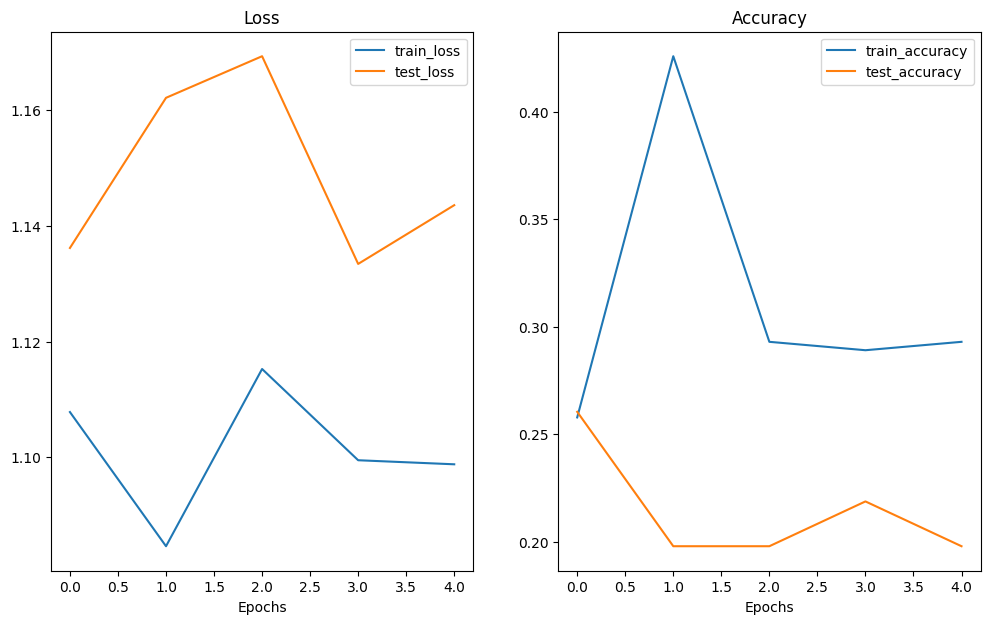

In [64]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

Looking at training and test loss curves is a great way to see if your model is **overfitting**.

An overfitting model is one that performs better (often by a considerable margin) on the training set than the validation/test set.

If your training loss is far lower than your test loss, your model is **overfitting**.

As in, it's learning the patterns in the training too well and those patterns aren't generalizing to the test data.

The other side is when your training and test loss are not as low as you'd like, this is considered **underfitting**.

The ideal position for a training and test loss curve is for them to line up closely with each other.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-loss-curves-overfitting-underfitting-ideal.jpg" alt="different training and test loss curves illustrating overfitting, underfitting and the ideal loss curves" width="800"/>

*Left: If your training and test loss curves aren't as low as you'd like, this is considered **underfitting**. *Middle:* When your test/validation loss is higher than your training loss this is considered **overfitting**. *Right:* The ideal scenario is when your training and test loss curves line up over time. This means your model is generalizing well. There are more combinations and different things loss curves can do, for more on these, see Google's [Interpreting Loss Curves guide](https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic).*

### 8.1 How to deal with overfitting

Since the main problem with overfitting is that your model is fitting the training data *too well*, you'll want to use techniques to "reign it in".

A common technique of preventing overfitting is known as [**regularization**](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html).

I like to think of this as "making our models more regular", as in, capable of fitting *more* kinds of data.

Let's discuss a few methods to prevent overfitting.

| **Method to prevent overfitting** | **What is it?** |
| ----- | ----- |
| **Get more data** | Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples. | 
| **Simplify your model** | If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer. | 
| **Use data augmentation** | [**Data augmentation**](https://developers.google.com/machine-learning/glossary#data-augmentation) manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data. |
| **Use transfer learning** | [**Transfer learning**](https://developers.google.com/machine-learning/glossary#transfer-learning) involves leveraging the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images. |
| **Use dropout layers** | Dropout layers randomly remove connections between hidden layers in neural networks, effectively simplifying a model but also making the remaining connections better. See [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) for more. | 
| **Use learning rate decay** | The idea here is to slowly decrease the learning rate as a model trains. This is akin to reaching for a coin at the back of a couch. The closer you get, the smaller your steps. The same with the learning rate, the closer you get to [**convergence**](https://developers.google.com/machine-learning/glossary#convergence), the smaller you'll want your weight updates to be.  |
| **Use early stopping** | [**Early stopping**](https://developers.google.com/machine-learning/glossary#early_stopping) stops model training *before* it begins to overfit. As in, say the model's loss has stopped decreasing for the past 10 epochs (this number is arbitrary), you may want to stop the model training here and go with the model weights that had the lowest loss (10 epochs prior). |

There are more methods for dealing with overfitting but these are some of the main ones.

As you start to build more and more deep models, you'll find because deep learnings are *so good* at learning patterns in data, dealing with overfitting is one of the primary problems of deep learning.